# Revolut ML Engineer NLP Challenge

## Notebook for bulding the predictive model

In [0]:
import string
import json
import re
from tqdm import tqdm
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tqdm.pandas()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop_words = set(stopwords.words("english"))

### Reading the datasets in pandas dataframe. We will read only users and products data that we identified in exploratory analysis

In [0]:
users_df = pd.read_csv("/content/gdrive/My Drive/Revolut-challenge/data/complaints_users.csv")
products_df = pd.read_csv("/content/gdrive/My Drive/Revolut-challenge/data/products.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Remove the NaN values from Products dataframe

In [0]:
products_df.loc[products_df.MAIN_PRODUCT == 'Payday loan', "SUB_PRODUCT"] = "Payday loan NaN"
products_df.loc[products_df.MAIN_PRODUCT == 'Credit reporting', "SUB_PRODUCT"] = "Credit reporting NaN"
products_df.loc[products_df.MAIN_PRODUCT == 'Credit card', "SUB_PRODUCT"] = "Credit card NaN"

### Let's join the users dataframe with the products dataframe to get one single dataframe

In [0]:
df = users_df.join(products_df.set_index('PRODUCT_ID'), on='PRODUCT_ID')

In [0]:
# Select required columns only
cols = ['COMPLAINT_ID', 'COMPLAINT_TEXT', 'PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']
df = df[cols]

## Handling data imbalance
Let's identify the product ids with less than 500 number of records

In [0]:
# Creating a dataframe with record counts for each product-id
count_df = pd.DataFrame({'COUNT': df.groupby(['PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']).size()}).reset_index()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

print(f'No. of Product Ids with less than 500 records: {count_df[count_df.COUNT < 500].shape[0]}')
count_df[count_df.COUNT < 500].head(100)

No. of Product Ids with less than 500 records: 39


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,COUNT
0,0,Bank account or service,(CD) Certificate of deposit,274
1,1,Bank account or service,Cashing a check without an account,134
5,5,Checking or savings account,CD (Certificate of Deposit),229
8,8,Checking or savings account,Personal line of credit,12
11,11,Consumer Loan,Pawn loan,34
12,12,Consumer Loan,Personal line of credit,44
13,13,Consumer Loan,Title loan,199
18,18,Credit card or prepaid card,Gift card,103
19,19,Credit card or prepaid card,Government benefit card,189
20,20,Credit card or prepaid card,Payroll card,91


In [0]:
prd_ids = list(count_df[count_df.COUNT < 500].PRODUCT_ID.values)
df = df[~df.PRODUCT_ID.isin(prd_ids)]

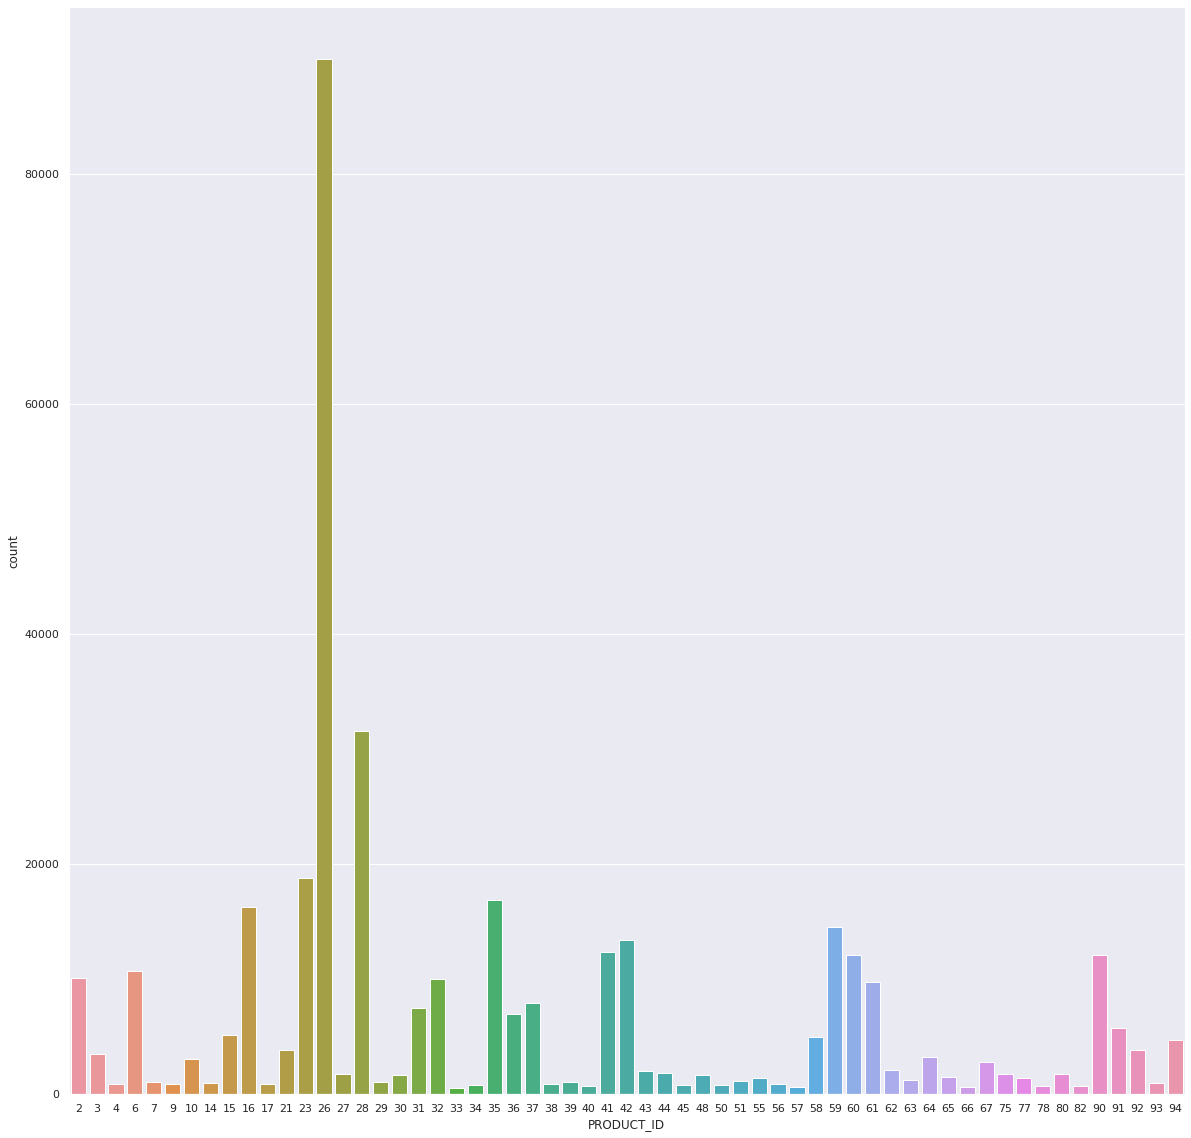

In [0]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
ax = sns.countplot(x="PRODUCT_ID", data=df)

In [0]:
df.head()

,COMPLAINT_ID,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
0,3184195,XXXX and Transunion are reporting incorrectly...,26,"Credit reporting, credit repair services, or o...",Credit reporting
1,3184692,XXXX and Transunion are reporting incorrectly ...,26,"Credit reporting, credit repair services, or o...",Credit reporting
2,3183613,"XXXX, XXXX, and Experian need to remove the co...",26,"Credit reporting, credit repair services, or o...",Credit reporting
3,3182430,"3 company with inconsistencies, violations and...",26,"Credit reporting, credit repair services, or o...",Credit reporting
4,3182218,I have a personal loan from Patriot finance. T...,26,"Credit reporting, credit repair services, or o...",Credit reporting


In [0]:
# Converting the text into lower case
def clean_text(text):
    text = text.lower()
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)"," ",text)
    text = re.sub("xxxx+", "", text)
    for word in stop_words:
        token = " " + word + " "
        text = text.replace(token, " ")
    text = re.compile(" +").sub(" ", text)
    return text
    
df.COMPLAINT_TEXT = df.COMPLAINT_TEXT.progress_map(clean_text)

100%|██████████| 379328/379328 [03:33<00:00, 1774.45it/s]


In [0]:
df.head()

,COMPLAINT_ID,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
0,3184195,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting
1,3184692,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting
2,3183613,experian need remove collection account submi...,26,"Credit reporting, credit repair services, or o...",Credit reporting
3,3182430,company inconsistencies violations double jeo...,26,"Credit reporting, credit repair services, or o...",Credit reporting
4,3182218,i personal loan patriot finance incorrectly re...,26,"Credit reporting, credit repair services, or o...",Credit reporting


In [0]:
df['PRODUCT_ID'] = df.PRODUCT_ID.astype('str')
df.set_index('COMPLAINT_ID', inplace=True)

In [0]:
prd_id_dict = {}
for idx, label in enumerate(df.PRODUCT_ID.unique()):
    prd_id_dict[label] = idx
labels = df.PRODUCT_ID.values

In [0]:
df['label'] = df.PRODUCT_ID.replace(prd_id_dict)
df.head()

,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,label
COMPLAINT_ID,,,,,
3184195,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3184692,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3183613,experian need remove collection account submi...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3182430,company inconsistencies violations double jeo...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3182218,i personal loan patriot finance incorrectly re...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.2,
    random_state=17,
    stratify=df.label.values
)

In [0]:
df_val_test = df.loc[X_val_test]

In [0]:
print(df_val_test.shape)
df_val_test.head()

(75866, 5)


,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,label
COMPLAINT_ID,,,,,
2709323,beginning public record date collected credit ...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
2441593,i withdrew cash local us b ank branch take ano...,2,Bank account or service,Checking account,40
1829090,my mortgage servicer ocwen flagged account nex...,59,Mortgage,Conventional fixed mortgage,45
1914797,transunion fails remove account transunion rep...,28,Credit reporting,Credit reporting NaN,35
2866898,i received statement debt provided contact sho...,32,Debt collection,Credit card debt,8


In [0]:
X_val, X_test, y_val, y_test = train_test_split(
    df_val_test.index.values,
    df_val_test.label.values,
    test_size=0.5,
    random_state=17,
    stratify=df_val_test.label.values
)

In [0]:
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [0]:
df[['PRODUCT_ID', 'COMPLAINT_TEXT', 'label', 'data_type']].groupby(['PRODUCT_ID', 'data_type']).count()

COMPLAINT_TEXT  label
PRODUCT_ID data_type                       
10         test                  310    310
           train                2475   2475
           val                   309    309
14         test                   96     96
           train                 770    770
           val                    96     96
15         test                  514    514
           train                4113   4113
           val                   514    514
16         test                 1625   1625
           train               12994  12994
           val                  1624   1624
17         test                   88     88
           train                 702    702
           val                    87     87
2          test                 1012   1012
           train                8090   8090
           val                  1011   1011
21         test                  384    384
           train                3070   3070
           val                   384    384
23         test                 1884   1884
           train               15070  15070
           val                  1884   1884
26         test                 8999   8999
           train               71995  71995
           val                  9000   9000
27         test                  176    176
           train                1410   1410
           val                   177    177
28         test                 3159   3159
           train               25270  25270
           val                  3159   3159
29         test                  107    107
           train                 851    851
           val                   106    106
3          test                  347    347
           train                2782   2782
           val                   348    348
30         test                  166    166
           train                1328   1328
           val                   166    166
31         test                  752    752
           train                6016   6016
           val                   752    752
32         test                 1002   1002
           train                8017   8017
           val                  1002   1002
33         test                   55     55
           train                 439    439
           val                    55     55
34         test                   80     80
           train                 636    636
           val                    79     79
35         test                 1688   1688
           train               13510  13510
           val                  1689   1689
36         test                  699    699
           train                5592   5592
           val                   699    699
37         test                  790    790
           train                6314   6314
           val                   789    789
38         test                   91     91
           train                 726    726
           val                    90     90
39         test                  111    111
           train                 890    890
           val                   111    111
4          test                   88     88
           train                 710    710
           val                    89     89
40         test                   69     69
           train                 547    547
           val                    68     68
41         test                 1240   1240
           train                9914   9914
           val                  1239   1239
42         test                 1338   1338
           train               10708  10708
           val                  1339   1339
43         test                  206    206
           train                1651   1651
           val                   207    207
44         test                  183    183
           train                1459   1459
           val                   182    182
45         test                   80     80
           train                 642    642
           val    

## Data is splitted correctly

In [0]:
train_sentences = df[df.data_type == 'train'].COMPLAINT_TEXT.values
print(len(train_sentences))
print(train_sentences[0])

303462
 transunion reporting incorrectly days past due loans partial account numbers accounts reflect balance past due contacted two bureaus requested coding errors corrected incorrect reporting harming credit score impossible past due accounts balance past due 


In [0]:
validation_sentences = list(df[df.data_type == 'val'].COMPLAINT_TEXT.values)
print(len(validation_sentences))
print(validation_sentences[0])

37933
i personal loan patriot finance incorrectly reporting loan derogatory status showing many days late payment agreement paying agreed account reflect 


In [0]:
test_sentences = list(df[df.data_type == 'test'].COMPLAINT_TEXT.values)
print(len(test_sentences))
print(test_sentences[0])

37933
experian failure remove report request validation investigation account acvd u c b received automated come remove account like credit reporting companies please so note account modified deleted carbon copy sent cra please remove account


In [0]:
train_labels = df[df.data_type == 'train'].label.values
validation_labels = df[df.data_type == 'val'].label.values
test_labels = df[df.data_type == 'test'].label.values

In [0]:
print(len(np.unique(train_labels)))
print(len(np.unique(validation_labels)))
print(len(np.unique(test_labels)))

59
59
59


In [0]:
from tensorflow.keras.utils import to_categorical
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [0]:
train_labels = encode(train_labels)
validation_labels = encode(validation_labels)
test_labels = encode(test_labels)

Shape of data (BEFORE encode): (303462,)
Shape of data (AFTER  encode): (303462, 59)

Shape of data (BEFORE encode): (37933,)
Shape of data (AFTER  encode): (37933, 59)

Shape of data (BEFORE encode): (37933,)
Shape of data (AFTER  encode): (37933, 59)



In [0]:
max_nb_words = 100000
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8
glove_dir = "/content/gdrive/My Drive/glove/glove.6B."+str(embedding_dim)+"d.txt"

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
tokenizer = Tokenizer(num_words = max_nb_words, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type,maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

34
200
34
200
7
200


In [0]:
import pickle
tokenizer_path = "/content/gdrive/My Drive/Revolut-challenge/model/tokenizer.pickle"
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
val_sequences = tokenizer.texts_to_sequences(validation_sentences)
val_padded = pad_sequences(val_sequences,padding=padding_type, truncating=trunc_type,maxlen=max_length)

In [0]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,padding=padding_type, truncating=trunc_type,maxlen=max_length)

In [0]:
embeddings_index = {}
f = open(glove_dir)
print('Loading GloVe from:', glove_dir,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/gdrive/My Drive//glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [0]:
embedding_matrix.shape

(94012, 100)

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    # return f1_score(labels_flat, preds_flat, average=None)
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in prd_id_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

# Model 1

In [0]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(59, activation='softmax')
])
adam = tf.keras.optimizers.Adam(lr=0.02)
model_1.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          9384600   
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 59)                7611      
Total params: 9,490,323
Trainable params: 9,490,323
Non-trainable params: 0
______________________________________________

In [0]:
num_epochs = 100
history_1 = model_1.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=2048,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
149/149 [==============================] - 38s 253ms/step - loss: 0.0639 - accuracy: 0.2571 - val_loss: 0.0540 - val_accuracy: 0.3445
Epoch 2/100
149/149 [==============================] - 37s 246ms/step - loss: 0.0487 - accuracy: 0.3827 - val_loss: 0.0446 - val_accuracy: 0.4341
Epoch 3/100
149/149 [==============================] - 37s 246ms/step - loss: 0.0430 - accuracy: 0.4565 - val_loss: 0.0422 - val_accuracy: 0.4692
Epoch 4/100
149/149 [==============================] - 37s 246ms/step - loss: 0.0403 - accuracy: 0.4906 - val_loss: 0.0404 - val_accuracy: 0.4892
Epoch 5/100
149/149 [==============================] - 37s 246ms/step - loss: 0.0385 - accuracy: 0.5133 - val_loss: 0.0395 - val_accuracy: 0.5052
Epoch 6/100
149/149 [==============================] - 37s 246ms/step - loss: 0.0375 - accuracy: 0.5273 - val_loss: 0.0396 - val_accuracy: 0.5005
Epoch 7/100
149/149 [==============================] - 36s 244ms/step - loss: 0.0369 - accuracy: 0.5375 - val_loss: 0.0393 -

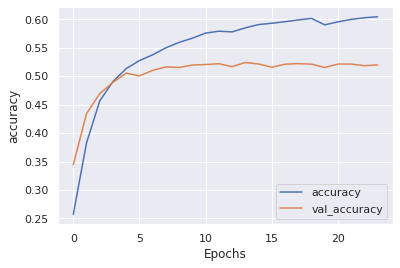

In [0]:
plot_graphs(history_1, 'accuracy')

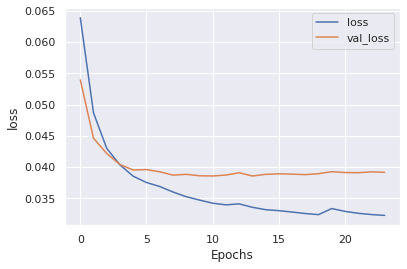

In [0]:
plot_graphs(history_1, 'loss')

In [0]:
predictions = model_1.predict(test_padded)

In [0]:
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: 26
Accuracy: 6927/8999

Class: 37
Accuracy: 310/790

Class: 39
Accuracy: 5/111

Class: 90
Accuracy: 945/1214

Class: 42
Accuracy: 572/1338

Class: 21
Accuracy: 71/384

Class: 60
Accuracy: 558/1210

Class: 35
Accuracy: 768/1688

Class: 32
Accuracy: 378/1002

Class: 45
Accuracy: 1/80

Class: 7
Accuracy: 3/104

Class: 6
Accuracy: 544/1071

Class: 44
Accuracy: 32/183

Class: 92
Accuracy: 79/389

Class: 48
Accuracy: 45/163

Class: 61
Accuracy: 290/979

Class: 34
Accuracy: 1/80

Class: 16
Accuracy: 703/1625

Class: 63
Accuracy: 22/122

Class: 27
Accuracy: 20/176

Class: 65
Accuracy: 0/151

Class: 9
Accuracy: 11/86

Class: 77
Accuracy: 26/142

Class: 94
Accuracy: 255/472

Class: 78
Accuracy: 3/75

Class: 17
Accuracy: 26/88

Class: 67
Accuracy: 94/284

Class: 93
Accuracy: 32/101

Class: 75
Accuracy: 16/174

Class: 66
Accuracy: 34/60

Class: 51
Accuracy: 16/120

Class: 55
Accuracy: 98/139

Class: 50
Accuracy: 17/79

Class: 30
Accuracy: 21/166

Class: 23
Accuracy: 1322/1884

Class: 28
Acc

In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.4996650806552406


# Model 2

In [0]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(59, activation='softmax')
])

adam = tf.keras.optimizers.Adam(lr=0.02)
model_2.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          9384600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 59)                3835      
Total params: 9,518,291
Trainable params: 9,518,291
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 100
history_2 = model_2.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=2048,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
149/149 [==============================] - 58s 391ms/step - loss: 0.0523 - accuracy: 0.3639 - val_loss: 0.0418 - val_accuracy: 0.4713
Epoch 2/100
149/149 [==============================] - 57s 382ms/step - loss: 0.0385 - accuracy: 0.5129 - val_loss: 0.0374 - val_accuracy: 0.5273
Epoch 3/100
149/149 [==============================] - 57s 382ms/step - loss: 0.0349 - accuracy: 0.5613 - val_loss: 0.0363 - val_accuracy: 0.5419
Epoch 4/100
149/149 [==============================] - 57s 381ms/step - loss: 0.0322 - accuracy: 0.5980 - val_loss: 0.0363 - val_accuracy: 0.5477
Epoch 5/100
149/149 [==============================] - 57s 380ms/step - loss: 0.0300 - accuracy: 0.6329 - val_loss: 0.0373 - val_accuracy: 0.5439
Epoch 6/100
149/149 [==============================] - 57s 381ms/step - loss: 0.0281 - accuracy: 0.6584 - val_loss: 0.0386 - val_accuracy: 0.5382
Epoch 7/100
149/149 [==============================] - 57s 380ms/step - loss: 0.0266 - accuracy: 0.6785 - val_loss: 0.0397 -

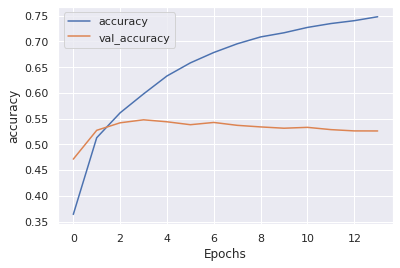

In [0]:
plot_graphs(history_2, 'accuracy')

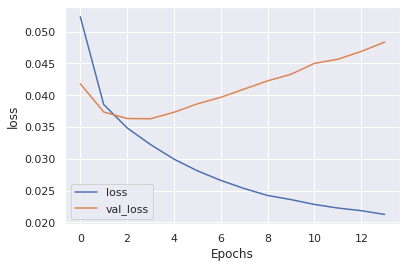

In [0]:
plot_graphs(history_2, 'loss')

In [0]:
predictions = model_2.predict(test_padded)

In [0]:
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: 26
Accuracy: 7035/8999

Class: 37
Accuracy: 299/790

Class: 39
Accuracy: 23/111

Class: 90
Accuracy: 855/1214

Class: 42
Accuracy: 600/1338

Class: 21
Accuracy: 99/384

Class: 60
Accuracy: 630/1210

Class: 35
Accuracy: 737/1688

Class: 32
Accuracy: 384/1002

Class: 45
Accuracy: 7/80

Class: 7
Accuracy: 4/104

Class: 6
Accuracy: 635/1071

Class: 44
Accuracy: 42/183

Class: 92
Accuracy: 121/389

Class: 48
Accuracy: 46/163

Class: 61
Accuracy: 239/979

Class: 34
Accuracy: 7/80

Class: 16
Accuracy: 904/1625

Class: 63
Accuracy: 34/122

Class: 27
Accuracy: 25/176

Class: 65
Accuracy: 5/151

Class: 9
Accuracy: 25/86

Class: 77
Accuracy: 43/142

Class: 94
Accuracy: 212/472

Class: 78
Accuracy: 6/75

Class: 17
Accuracy: 39/88

Class: 67
Accuracy: 87/284

Class: 93
Accuracy: 39/101

Class: 75
Accuracy: 33/174

Class: 66
Accuracy: 39/60

Class: 51
Accuracy: 42/120

Class: 55
Accuracy: 71/139

Class: 50
Accuracy: 23/79

Class: 30
Accuracy: 28/166

Class: 23
Accuracy: 1142/1884

Class: 28
A

In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.5148230858183126


# Model 3

In [0]:
model_3 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.LSTM(60),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(59, activation='softmax')
])

adam = tf.keras.optimizers.Adam(lr=0.02)
model_3.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          9384600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 49, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [0]:
num_epochs = 100
history_3 = model_3.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=256,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
1186/1186 [==============================] - 23s 19ms/step - loss: 2.3648 - accuracy: 0.3244 - val_loss: 2.0363 - val_accuracy: 0.3661
Epoch 2/100
1186/1186 [==============================] - 22s 18ms/step - loss: 2.1779 - accuracy: 0.3465 - val_loss: 2.0366 - val_accuracy: 0.3660
Epoch 3/100
1186/1186 [==============================] - 22s 19ms/step - loss: 2.1623 - accuracy: 0.3490 - val_loss: 2.0092 - val_accuracy: 0.3688
Epoch 4/100
1186/1186 [==============================] - 22s 19ms/step - loss: 2.1629 - accuracy: 0.3507 - val_loss: 2.0047 - val_accuracy: 0.3689
Epoch 5/100
1186/1186 [==============================] - 22s 19ms/step - loss: 2.1732 - accuracy: 0.3497 - val_loss: 2.0172 - val_accuracy: 0.3615
Epoch 6/100
1186/1186 [==============================] - 22s 19ms/step - loss: 2.1618 - accuracy: 0.3507 - val_loss: 2.0014 - val_accuracy: 0.3648
Epoch 7/100
1186/1186 [==============================] - 22s 19ms/step - loss: 2.1713 - accuracy: 0.3487 - val_loss: 1

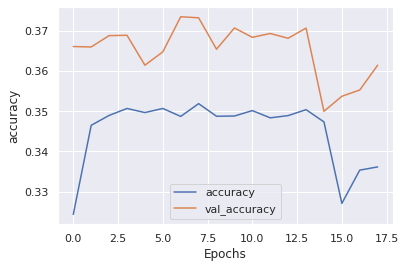

In [0]:
plot_graphs(history_3, 'accuracy')

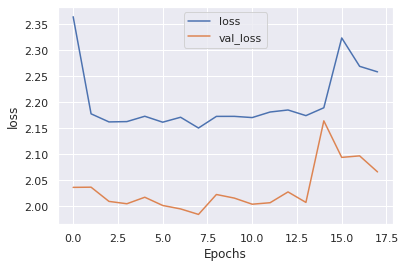

In [0]:
plot_graphs(history_3, 'loss')

In [0]:
predictions = model_3.predict(test_padded)

In [0]:
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: 26
Accuracy: 7596/8999

Class: 37
Accuracy: 296/790

Class: 39
Accuracy: 0/111

Class: 90
Accuracy: 996/1214

Class: 42
Accuracy: 0/1338

Class: 21
Accuracy: 0/384

Class: 60
Accuracy: 0/1210

Class: 35
Accuracy: 465/1688

Class: 32
Accuracy: 7/1002

Class: 45
Accuracy: 0/80

Class: 7
Accuracy: 0/104

Class: 6
Accuracy: 44/1071

Class: 44
Accuracy: 0/183

Class: 92
Accuracy: 0/389

Class: 48
Accuracy: 0/163

Class: 61
Accuracy: 0/979

Class: 34
Accuracy: 0/80

Class: 16
Accuracy: 60/1625

Class: 63
Accuracy: 0/122

Class: 27
Accuracy: 0/176

Class: 65
Accuracy: 0/151

Class: 9
Accuracy: 0/86

Class: 77
Accuracy: 0/142

Class: 94
Accuracy: 179/472

Class: 78
Accuracy: 0/75

Class: 17
Accuracy: 0/88

Class: 67
Accuracy: 0/284

Class: 93
Accuracy: 0/101

Class: 75
Accuracy: 0/174

Class: 66
Accuracy: 0/60

Class: 51
Accuracy: 0/120

Class: 55
Accuracy: 0/139

Class: 50
Accuracy: 0/79

Class: 30
Accuracy: 0/166

Class: 23
Accuracy: 1267/1884

Class: 28
Accuracy: 1/3159

Class: 36
Ac

In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.2536202412022736


# Model 4

In [0]:
model_4 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(59, activation='softmax')
])

adam = tf.keras.optimizers.Adam(lr=0.02)
model_4.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          9384600   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 59)               

In [0]:
num_epochs = 100
history_4 = model_4.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=256,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
1186/1186 [==============================] - 27s 23ms/step - loss: 1.9628 - accuracy: 0.4026 - val_loss: 1.7270 - val_accuracy: 0.4547
Epoch 2/100
1186/1186 [==============================] - 27s 23ms/step - loss: 1.7911 - accuracy: 0.4366 - val_loss: 1.6774 - val_accuracy: 0.4597
Epoch 3/100
1186/1186 [==============================] - 27s 23ms/step - loss: 1.7589 - accuracy: 0.4468 - val_loss: 1.6615 - val_accuracy: 0.4713
Epoch 4/100
1186/1186 [==============================] - 27s 23ms/step - loss: 1.7371 - accuracy: 0.4498 - val_loss: 1.6686 - val_accuracy: 0.4709
Epoch 5/100
1186/1186 [==============================] - 27s 23ms/step - loss: 1.7292 - accuracy: 0.4521 - val_loss: 1.6567 - val_accuracy: 0.4642
Epoch 6/100
1186/1186 [==============================] - 27s 23ms/step - loss: 1.7259 - accuracy: 0.4530 - val_loss: 1.6465 - val_accuracy: 0.4759
Epoch 7/100
1186/1186 [==============================] - 27s 23ms/step - loss: 1.7188 - accuracy: 0.4556 - val_loss: 1

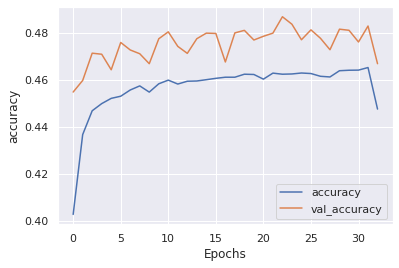

In [0]:
plot_graphs(history_4, 'accuracy')

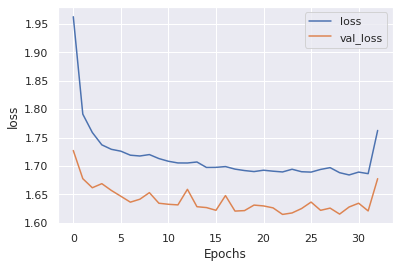

In [0]:
plot_graphs(history_4, 'loss')

In [0]:
predictions = model_4.predict(test_padded)

In [0]:
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: 26
Accuracy: 7921/8999

Class: 37
Accuracy: 134/790

Class: 39
Accuracy: 2/111

Class: 90
Accuracy: 666/1214

Class: 42
Accuracy: 443/1338

Class: 21
Accuracy: 86/384

Class: 60
Accuracy: 649/1210

Class: 35
Accuracy: 764/1688

Class: 32
Accuracy: 248/1002

Class: 45
Accuracy: 0/80

Class: 7
Accuracy: 0/104

Class: 6
Accuracy: 690/1071

Class: 44
Accuracy: 33/183

Class: 92
Accuracy: 44/389

Class: 48
Accuracy: 8/163

Class: 61
Accuracy: 190/979

Class: 34
Accuracy: 0/80

Class: 16
Accuracy: 804/1625

Class: 63
Accuracy: 14/122

Class: 27
Accuracy: 5/176

Class: 65
Accuracy: 0/151

Class: 9
Accuracy: 4/86

Class: 77
Accuracy: 7/142

Class: 94
Accuracy: 114/472

Class: 78
Accuracy: 0/75

Class: 17
Accuracy: 38/88

Class: 67
Accuracy: 35/284

Class: 93
Accuracy: 31/101

Class: 75
Accuracy: 23/174

Class: 66
Accuracy: 14/60

Class: 51
Accuracy: 13/120

Class: 55
Accuracy: 92/139

Class: 50
Accuracy: 18/79

Class: 30
Accuracy: 7/166

Class: 23
Accuracy: 1061/1884

Class: 28
Accuracy

In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.4220020965137315


## Let us try a simple model with glove embeddings and see how that performs

# Model 5

In [0]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(59, activation='softmax')
])
adam = tf.keras.optimizers.Adam(lr=0.02)
model_5.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          9384600   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_8 (Dense)              (None, 59)                7611      
Total params: 9,405,139
Trainable params: 9,405,139
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 100
history_5 = model_5.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=2048,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
149/149 [==============================] - 30s 202ms/step - loss: 2.0852 - accuracy: 0.3983 - val_loss: 1.5854 - val_accuracy: 0.4973
Epoch 2/100
149/149 [==============================] - 30s 199ms/step - loss: 1.4526 - accuracy: 0.5298 - val_loss: 1.5057 - val_accuracy: 0.5194
Epoch 3/100
149/149 [==============================] - 30s 199ms/step - loss: 1.2949 - accuracy: 0.5753 - val_loss: 1.4796 - val_accuracy: 0.5317
Epoch 4/100
149/149 [==============================] - 30s 200ms/step - loss: 1.1715 - accuracy: 0.6116 - val_loss: 1.5329 - val_accuracy: 0.5243
Epoch 5/100
149/149 [==============================] - 30s 199ms/step - loss: 1.0636 - accuracy: 0.6471 - val_loss: 1.5847 - val_accuracy: 0.5243
Epoch 6/100
149/149 [==============================] - 30s 199ms/step - loss: 0.9599 - accuracy: 0.6823 - val_loss: 1.6781 - val_accuracy: 0.5247
Epoch 7/100
149/149 [==============================] - 30s 200ms/step - loss: 0.8654 - accuracy: 0.7153 - val_loss: 1.7565 -

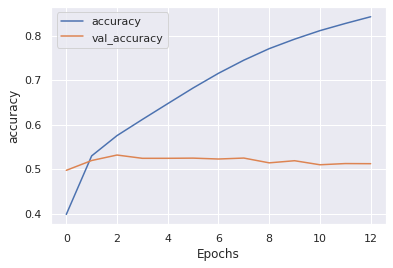

In [0]:
plot_graphs(history_5, 'accuracy')

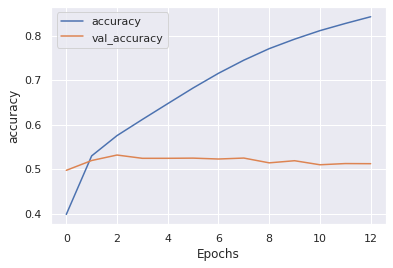

In [0]:
plot_graphs(history_5, 'accuracy')

In [0]:
predictions = model_5.predict(test_padded)
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: 26
Accuracy: 7156/8999

Class: 37
Accuracy: 350/790

Class: 39
Accuracy: 28/111

Class: 90
Accuracy: 740/1214

Class: 42
Accuracy: 486/1338

Class: 21
Accuracy: 79/384

Class: 60
Accuracy: 449/1210

Class: 35
Accuracy: 915/1688

Class: 32
Accuracy: 339/1002

Class: 45
Accuracy: 11/80

Class: 7
Accuracy: 4/104

Class: 6
Accuracy: 531/1071

Class: 44
Accuracy: 53/183

Class: 92
Accuracy: 138/389

Class: 48
Accuracy: 60/163

Class: 61
Accuracy: 362/979

Class: 34
Accuracy: 13/80

Class: 16
Accuracy: 763/1625

Class: 63
Accuracy: 18/122

Class: 27
Accuracy: 29/176

Class: 65
Accuracy: 9/151

Class: 9
Accuracy: 15/86

Class: 77
Accuracy: 25/142

Class: 94
Accuracy: 162/472

Class: 78
Accuracy: 7/75

Class: 17
Accuracy: 32/88

Class: 67
Accuracy: 86/284

Class: 93
Accuracy: 43/101

Class: 75
Accuracy: 22/174

Class: 66
Accuracy: 35/60

Class: 51
Accuracy: 26/120

Class: 55
Accuracy: 69/139

Class: 50
Accuracy: 26/79

Class: 30
Accuracy: 24/166

Class: 23
Accuracy: 1098/1884

Class: 28

In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.5043200247223568


# Model 6

In [0]:
model_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(59, activation='softmax')
])
adam = tf.keras.optimizers.Adam(lr=0.02)
model_6.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          9384600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 59)               

In [0]:
num_epochs = 100
history_6 = model_6.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=2048,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
149/149 [==============================] - 30s 203ms/step - loss: 2.1228 - accuracy: 0.3885 - val_loss: 1.6183 - val_accuracy: 0.4894
Epoch 2/100
149/149 [==============================] - 30s 202ms/step - loss: 1.5203 - accuracy: 0.5089 - val_loss: 1.5217 - val_accuracy: 0.5138
Epoch 3/100
149/149 [==============================] - 30s 200ms/step - loss: 1.3799 - accuracy: 0.5477 - val_loss: 1.4863 - val_accuracy: 0.5261
Epoch 4/100
149/149 [==============================] - 30s 202ms/step - loss: 1.2845 - accuracy: 0.5752 - val_loss: 1.4911 - val_accuracy: 0.5302
Epoch 5/100
149/149 [==============================] - 30s 201ms/step - loss: 1.2075 - accuracy: 0.5988 - val_loss: 1.5134 - val_accuracy: 0.5293
Epoch 6/100
149/149 [==============================] - 30s 202ms/step - loss: 1.1336 - accuracy: 0.6210 - val_loss: 1.5605 - val_accuracy: 0.5256
Epoch 7/100
149/149 [==============================] - 30s 202ms/step - loss: 1.0760 - accuracy: 0.6399 - val_loss: 1.6023 -

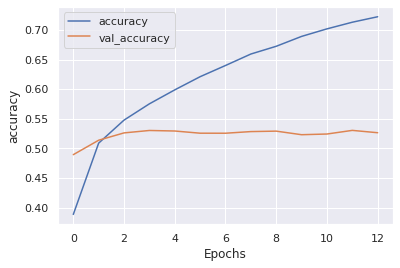

In [0]:
plot_graphs(history_6, 'accuracy')

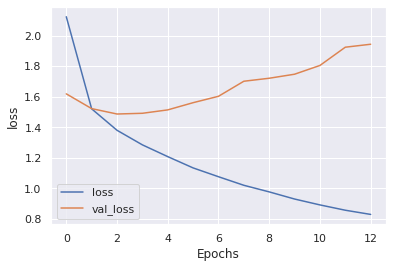

In [0]:
plot_graphs(history_6, 'loss')

In [0]:
predictions = model_6.predict(test_padded)
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: 26
Accuracy: 7261/8999

Class: 37
Accuracy: 353/790

Class: 39
Accuracy: 22/111

Class: 90
Accuracy: 877/1214

Class: 42
Accuracy: 552/1338

Class: 21
Accuracy: 102/384

Class: 60
Accuracy: 559/1210

Class: 35
Accuracy: 860/1688

Class: 32
Accuracy: 406/1002

Class: 45
Accuracy: 12/80

Class: 7
Accuracy: 6/104

Class: 6
Accuracy: 569/1071

Class: 44
Accuracy: 34/183

Class: 92
Accuracy: 128/389

Class: 48
Accuracy: 52/163

Class: 61
Accuracy: 313/979

Class: 34
Accuracy: 15/80

Class: 16
Accuracy: 712/1625

Class: 63
Accuracy: 29/122

Class: 27
Accuracy: 26/176

Class: 65
Accuracy: 6/151

Class: 9
Accuracy: 12/86

Class: 77
Accuracy: 27/142

Class: 94
Accuracy: 172/472

Class: 78
Accuracy: 5/75

Class: 17
Accuracy: 33/88

Class: 67
Accuracy: 106/284

Class: 93
Accuracy: 45/101

Class: 75
Accuracy: 32/174

Class: 66
Accuracy: 34/60

Class: 51
Accuracy: 22/120

Class: 55
Accuracy: 78/139

Class: 50
Accuracy: 21/79

Class: 30
Accuracy: 38/166

Class: 23
Accuracy: 1186/1884

Class: 

In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.5159504747589624


# Overfitting
The last two models are evidently overfitting on training data but not able to generalise well on validation data. We do not have sufficient data points for other classes for the model to generalise well.

# Alternate approach:
Let's try a different approach where we can first build a model to predict the Main Product and see how the model performs:

In [0]:
# df.head()

In [0]:
import string
import json
import re
from tqdm import tqdm
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords
tqdm.pandas()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
users_df = pd.read_csv("/content/gdrive/My Drive/Revolut-challenge/data/complaints_users.csv")
products_df = pd.read_csv("/content/gdrive/My Drive/Revolut-challenge/data/products.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
products_df.loc[products_df.MAIN_PRODUCT == 'Payday loan', "SUB_PRODUCT"] = "Payday loan NaN"
products_df.loc[products_df.MAIN_PRODUCT == 'Credit reporting', "SUB_PRODUCT"] = "Credit reporting NaN"
products_df.loc[products_df.MAIN_PRODUCT == 'Credit card', "SUB_PRODUCT"] = "Credit card NaN"

In [0]:
df = users_df.join(products_df.set_index('PRODUCT_ID'), on='PRODUCT_ID')

In [0]:
# Select required columns only
cols = ['COMPLAINT_ID', 'COMPLAINT_TEXT', 'PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']
df = df[cols]

In [0]:
# Creating a dataframe with record counts for each product-id
count_df = pd.DataFrame({'COUNT': df.groupby(['PRODUCT_ID', 'MAIN_PRODUCT', 'SUB_PRODUCT']).size()}).reset_index()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

print(f'No. of Product Ids with less than 500 records: {count_df[count_df.COUNT < 500].shape[0]}')
count_df[count_df.COUNT < 500].head(100)

No. of Product Ids with less than 500 records: 39


,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,COUNT
0,0,Bank account or service,(CD) Certificate of deposit,274
1,1,Bank account or service,Cashing a check without an account,134
5,5,Checking or savings account,CD (Certificate of Deposit),229
8,8,Checking or savings account,Personal line of credit,12
11,11,Consumer Loan,Pawn loan,34
12,12,Consumer Loan,Personal line of credit,44
13,13,Consumer Loan,Title loan,199
18,18,Credit card or prepaid card,Gift card,103
19,19,Credit card or prepaid card,Government benefit card,189
20,20,Credit card or prepaid card,Payroll card,91


In [0]:
prd_ids = list(count_df[count_df.COUNT < 500].PRODUCT_ID.values)
df = df[~df.PRODUCT_ID.isin(prd_ids)]

In [0]:
df.head()

,COMPLAINT_ID,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT
0,3184195,XXXX and Transunion are reporting incorrectly...,26,"Credit reporting, credit repair services, or o...",Credit reporting
1,3184692,XXXX and Transunion are reporting incorrectly ...,26,"Credit reporting, credit repair services, or o...",Credit reporting
2,3183613,"XXXX, XXXX, and Experian need to remove the co...",26,"Credit reporting, credit repair services, or o...",Credit reporting
3,3182430,"3 company with inconsistencies, violations and...",26,"Credit reporting, credit repair services, or o...",Credit reporting
4,3182218,I have a personal loan from Patriot finance. T...,26,"Credit reporting, credit repair services, or o...",Credit reporting


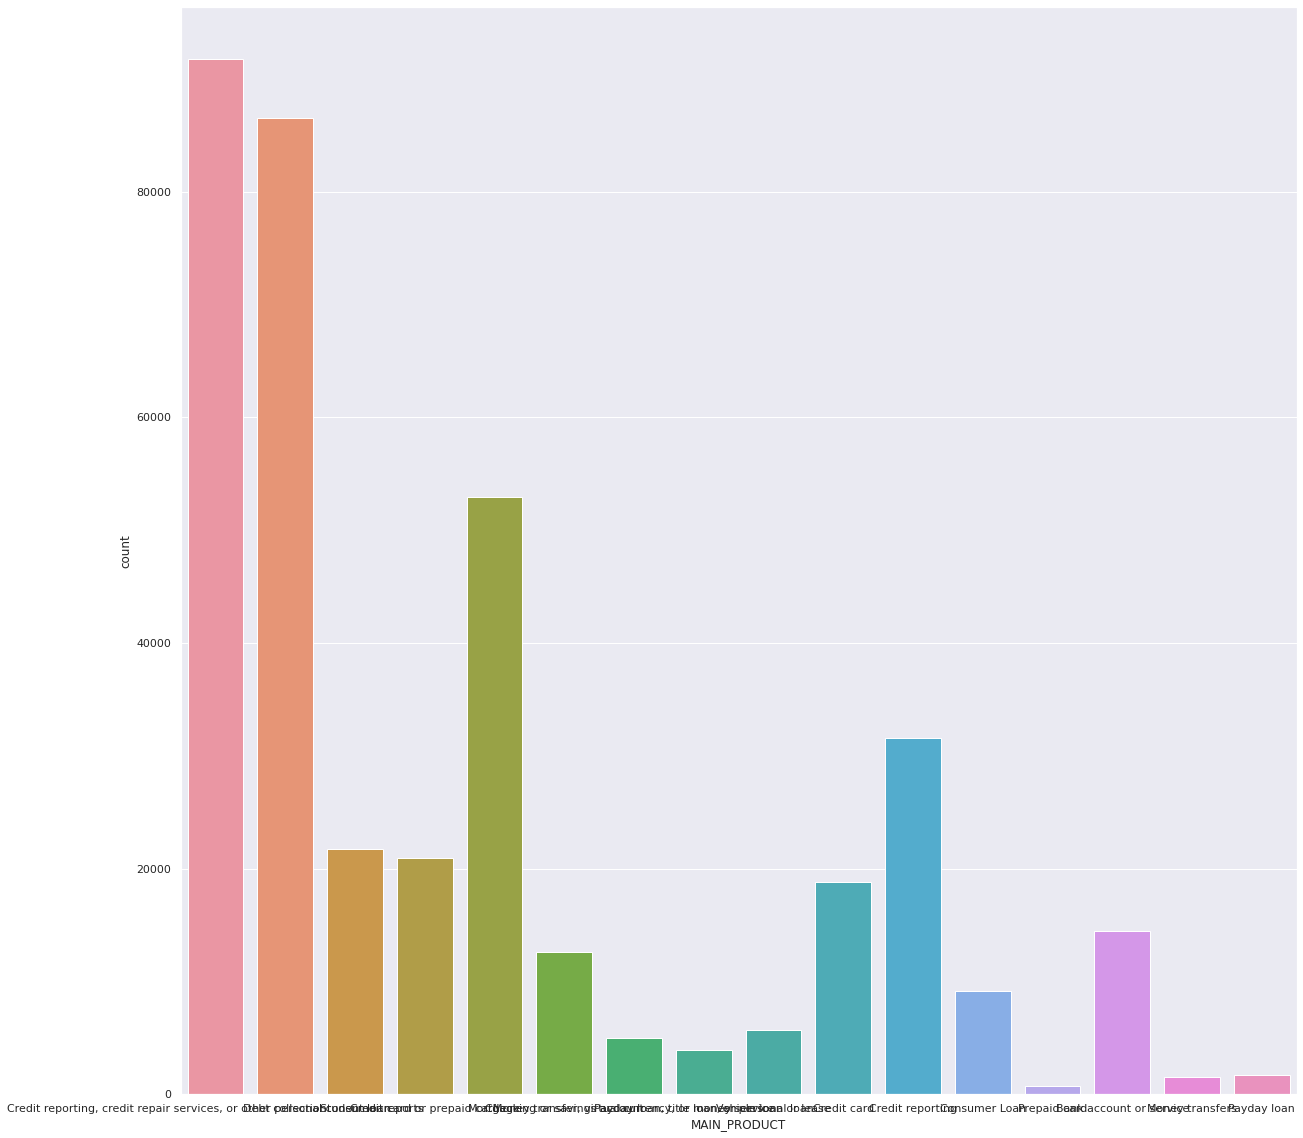

In [0]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
ax = sns.countplot(x="MAIN_PRODUCT", data=df)

In [0]:
main_prd_dict = {}
for idx, label in enumerate(df.MAIN_PRODUCT.unique()):
    main_prd_dict[label] = idx

In [0]:
df['label'] = df.MAIN_PRODUCT.replace(main_prd_dict)

In [0]:
df.head()

,COMPLAINT_ID,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,label
0,3184195,XXXX and Transunion are reporting incorrectly...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
1,3184692,XXXX and Transunion are reporting incorrectly ...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0
2,3183613,"XXXX, XXXX, and Experian need to remove the co...",26,"Credit reporting, credit repair services, or o...",Credit reporting,0
3,3182430,"3 company with inconsistencies, violations and...",26,"Credit reporting, credit repair services, or o...",Credit reporting,0
4,3182218,I have a personal loan from Patriot finance. T...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0


In [0]:
labels = df.label.values

In [0]:
df.set_index('COMPLAINT_ID', inplace=True)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.2,
    random_state=17,
    stratify=df.label.values
)

In [0]:
df_val_test = df.loc[X_val_test]

In [0]:
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(
    df_val_test.index.values,
    df_val_test.label.values,
    test_size=0.5,
    random_state=17,
    stratify=df_val_test.label.values
)

In [0]:
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [0]:
df[['MAIN_PRODUCT', 'COMPLAINT_TEXT', 'label', 'data_type']].groupby(['MAIN_PRODUCT', 'data_type']).count()

COMPLAINT_TEXT  \
MAIN_PRODUCT                                       data_type                   
Bank account or service                            test                 1447   
                                                   train               11582   
                                                   val                  1448   
Checking or savings account                        test                 1262   
                                                   train               10094   
                                                   val                  1261   
Consumer Loan                                      test                  919   
                                                   train                7358   
                                                   val                   920   
Credit card                                        test                 1884   
                                                   train               15070   
                                                   val                  1884   
Credit card or prepaid card                        test                 2096   
                                                   train               16766   
                                                   val                  2096   
Credit reporting                                   test                 3159   
                                                   train               25270   
                                                   val                  3159   
Credit reporting, credit repair services, or ot... test                 9176   
                                                   train               73405   
                                                   val                  9176   
Debt collection                                    test                 8655   
                                                   train               69240   
                                                   val                  8655   
Money transfer, virtual currency, or money service test                  501   
                                                   train                4011   
                                                   val                   502   
Money transfers                                    test                  150   
                                                   train                1198   
                                                   val                   149   
Mortgage                                           test                 5294   
                                                   train               42348   
                                                   val                  5293   
Payday loan                                        test                  175   
                                                   train                1398   
                                                   val                   174   
Payday loan, title loan, or personal loan          test                  392   
                                                   train                3134   
                                                   val                   392   
Prepaid card                                       test                   73   
                                                   train                 584   
                                                   val                    73   
Student loan                                       test                 2178   
                                                   train               17423   
                                                   val                  2178   
Vehicle loan or lease                              test                  572   
                                                   train                4581   
                                                   val                   573   

                                                             

In [0]:
df.head()

,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,label,data_type
COMPLAINT_ID,,,,,,
3184195,XXXX and Transunion are reporting incorrectly...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0,train
3184692,XXXX and Transunion are reporting incorrectly ...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0,train
3183613,"XXXX, XXXX, and Experian need to remove the co...",26,"Credit reporting, credit repair services, or o...",Credit reporting,0,train
3182430,"3 company with inconsistencies, violations and...",26,"Credit reporting, credit repair services, or o...",Credit reporting,0,train
3182218,I have a personal loan from Patriot finance. T...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0,val


In [0]:
max_nb_words = 100000
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8
glove_dir = "/content/gdrive/My Drive//glove/glove.6B."+str(embedding_dim)+"d.txt"

stop_words = set(stopwords.words("english"))

In [0]:
# Converting the text into lower case
def clean_text(text):
    text = text.lower()
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)"," ",text)
    text = re.sub("xxxx+", "", text)
    for word in stop_words:
        token = " " + word + " "
        text = text.replace(token, " ")
    text = re.compile(" +").sub(" ", text)
    return text
    
df.COMPLAINT_TEXT = df.COMPLAINT_TEXT.progress_map(clean_text)

100%|██████████| 379328/379328 [03:30<00:00, 1805.80it/s]


In [0]:
df.head()

,COMPLAINT_TEXT,PRODUCT_ID,MAIN_PRODUCT,SUB_PRODUCT,label,data_type
COMPLAINT_ID,,,,,,
3184195,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0,train
3184692,transunion reporting incorrectly days past du...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0,train
3183613,experian need remove collection account submi...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0,train
3182430,company inconsistencies violations double jeo...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0,train
3182218,i personal loan patriot finance incorrectly re...,26,"Credit reporting, credit repair services, or o...",Credit reporting,0,val


In [0]:
train_sentences = df[df.data_type == 'train'].COMPLAINT_TEXT.values
print(len(train_sentences))
print(train_sentences[0])

303462
 transunion reporting incorrectly days past due loans partial account numbers accounts reflect balance past due contacted two bureaus requested coding errors corrected incorrect reporting harming credit score impossible past due accounts balance past due 


In [0]:
validation_sentences = list(df[df.data_type == 'val'].COMPLAINT_TEXT.values)
print(len(validation_sentences))
print(validation_sentences[0])

test_sentences = list(df[df.data_type == 'test'].COMPLAINT_TEXT.values)
print(len(test_sentences))
print(test_sentences[0])

37933
i personal loan patriot finance incorrectly reporting loan derogatory status showing many days late payment agreement paying agreed account reflect 
37933
i met requirements ability benefit exact letter law knowingly falsified findings continue garnish wages exactly person law designed simply ignored law continue ruin financially someone needs investigate continue let politicians get away type behavior please investigate department education collection agency use ruin peoples lives promise investigate case see met requirement ask look claim people committed fraud deny claim 


In [0]:
from tensorflow.keras.utils import to_categorical

def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [0]:
train_labels = df[df.data_type == 'train'].label.values
validation_labels = df[df.data_type == 'val'].label.values
test_labels = df[df.data_type == 'test'].label.values
train_labels = encode(train_labels)
validation_labels = encode(validation_labels)
test_labels = encode(test_labels)

Shape of data (BEFORE encode): (303462,)
Shape of data (AFTER  encode): (303462, 16)

Shape of data (BEFORE encode): (37933,)
Shape of data (AFTER  encode): (37933, 16)

Shape of data (BEFORE encode): (37933,)
Shape of data (AFTER  encode): (37933, 16)



In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
tokenizer = Tokenizer(num_words = max_nb_words, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type,maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

34
200
34
200
7
200


In [0]:
val_sequences = tokenizer.texts_to_sequences(validation_sentences)
val_padded = pad_sequences(val_sequences,padding=padding_type, truncating=trunc_type,maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,padding=padding_type, truncating=trunc_type,maxlen=max_length)

In [0]:
embeddings_index = {}
f = open(glove_dir)
print('Loading GloVe from:', glove_dir,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/gdrive/My Drive//glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [0]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    # return f1_score(labels_flat, preds_flat, average=None)
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in main_prd_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# Model 7

In [0]:
model_7 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='softmax')
])
adam = tf.keras.optimizers.Adam(lr=0.02)
model_7.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          9401100   
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2

In [0]:
num_epochs = 100
history_7 = model_7.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=2048,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
149/149 [==============================] - 9s 59ms/step - loss: 1.9765 - accuracy: 0.3473 - val_loss: 1.7149 - val_accuracy: 0.4691
Epoch 2/100
149/149 [==============================] - 9s 58ms/step - loss: 1.7987 - accuracy: 0.4095 - val_loss: 1.6790 - val_accuracy: 0.4329
Epoch 3/100
149/149 [==============================] - 8s 57ms/step - loss: 1.7710 - accuracy: 0.4177 - val_loss: 1.6533 - val_accuracy: 0.4789
Epoch 4/100
149/149 [==============================] - 9s 58ms/step - loss: 1.7570 - accuracy: 0.4211 - val_loss: 1.6311 - val_accuracy: 0.4824
Epoch 5/100
149/149 [==============================] - 9s 58ms/step - loss: 1.7406 - accuracy: 0.4271 - val_loss: 1.6273 - val_accuracy: 0.4653
Epoch 6/100
149/149 [==============================] - 9s 57ms/step - loss: 1.7283 - accuracy: 0.4321 - val_loss: 1.6147 - val_accuracy: 0.4839
Epoch 7/100
149/149 [==============================] - 9s 57ms/step - loss: 1.7201 - accuracy: 0.4335 - val_loss: 1.6052 - val_accuracy:

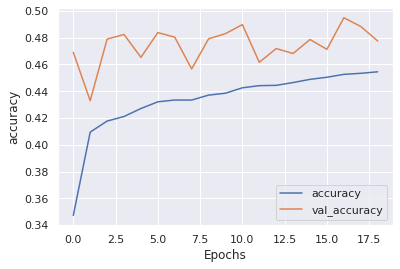

In [0]:
plot_graphs(history_7, 'accuracy')

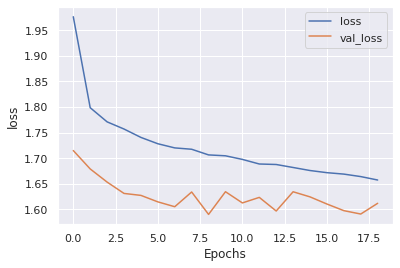

In [0]:
plot_graphs(history_7, 'loss')

In [0]:
predictions = model_7.predict(test_padded)
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: Credit reporting, credit repair services, or other personal consumer reports
Accuracy: 7858/9176

Class: Debt collection
Accuracy: 3964/8655

Class: Student loan
Accuracy: 876/2178

Class: Credit card or prepaid card
Accuracy: 507/2096

Class: Mortgage
Accuracy: 3889/5294

Class: Checking or savings account
Accuracy: 225/1262

Class: Money transfer, virtual currency, or money service
Accuracy: 37/501

Class: Payday loan, title loan, or personal loan
Accuracy: 1/392

Class: Vehicle loan or lease
Accuracy: 33/572

Class: Credit card
Accuracy: 169/1884

Class: Credit reporting
Accuracy: 10/3159

Class: Consumer Loan
Accuracy: 49/919

Class: Prepaid card
Accuracy: 0/73

Class: Bank account or service
Accuracy: 365/1447

Class: Money transfers
Accuracy: 3/150

Class: Payday loan
Accuracy: 0/175

None


In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.415081897830139


# Model 8

Let us try fine tuning the glove embedding

In [0]:
model_8 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='softmax')
])
adam = tf.keras.optimizers.Adam(lr=0.02)
model_8.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_8.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          9401100   
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

In [0]:
num_epochs = 100
history_8 = model_8.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=2048,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
149/149 [==============================] - 29s 197ms/step - loss: 1.3474 - accuracy: 0.5597 - val_loss: 0.8715 - val_accuracy: 0.6987
Epoch 2/100
149/149 [==============================] - 29s 195ms/step - loss: 0.8359 - accuracy: 0.7081 - val_loss: 0.7798 - val_accuracy: 0.7237
Epoch 3/100
149/149 [==============================] - 29s 196ms/step - loss: 0.7437 - accuracy: 0.7344 - val_loss: 0.7532 - val_accuracy: 0.7313
Epoch 4/100
149/149 [==============================] - 29s 194ms/step - loss: 0.6862 - accuracy: 0.7528 - val_loss: 0.7505 - val_accuracy: 0.7326
Epoch 5/100
149/149 [==============================] - 29s 194ms/step - loss: 0.6387 - accuracy: 0.7685 - val_loss: 0.7429 - val_accuracy: 0.7419
Epoch 6/100
149/149 [==============================] - 29s 196ms/step - loss: 0.5986 - accuracy: 0.7816 - val_loss: 0.7645 - val_accuracy: 0.7390
Epoch 7/100
149/149 [==============================] - 29s 195ms/step - loss: 0.5635 - accuracy: 0.7938 - val_loss: 0.7719 -

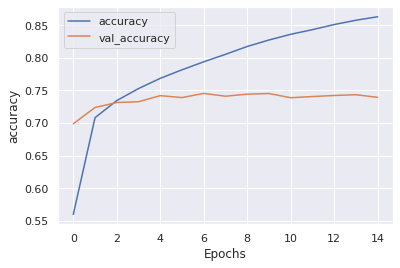

In [0]:
plot_graphs(history_8, 'accuracy')

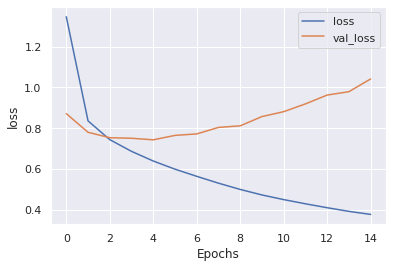

In [0]:
plot_graphs(history_8, 'loss')

In [0]:
predictions = model_8.predict(test_padded)
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: Credit reporting, credit repair services, or other personal consumer reports
Accuracy: 7344/9176

Class: Debt collection
Accuracy: 7675/8655

Class: Student loan
Accuracy: 1921/2178

Class: Credit card or prepaid card
Accuracy: 1125/2096

Class: Mortgage
Accuracy: 4929/5294

Class: Checking or savings account
Accuracy: 669/1262

Class: Money transfer, virtual currency, or money service
Accuracy: 353/501

Class: Payday loan, title loan, or personal loan
Accuracy: 131/392

Class: Vehicle loan or lease
Accuracy: 243/572

Class: Credit card
Accuracy: 950/1884

Class: Credit reporting
Accuracy: 1238/3159

Class: Consumer Loan
Accuracy: 360/919

Class: Prepaid card
Accuracy: 30/73

Class: Bank account or service
Accuracy: 805/1447

Class: Money transfers
Accuracy: 64/150

Class: Payday loan
Accuracy: 59/175

None


In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.7265221942153044


## The above plot shows that model 8 is overfitting though the f1 score is better than other models

# Model 9
Let's try a bit more complicated model and see how it performs

In [0]:
model_9 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='softmax')
])

adam = tf.keras.optimizers.Adam(lr=0.02)
model_9.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model_9.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          9401200   
_________________________________________________________________
dropout (Dropout)            (None, 200, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 49, 128)           66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 49, 128)           0

In [0]:
num_epochs = 100
history_9 = model_9.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=2048,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
149/149 [==============================] - 61s 407ms/step - loss: 1.7261 - accuracy: 0.4162 - val_loss: 1.2639 - val_accuracy: 0.5713
Epoch 2/100
149/149 [==============================] - 59s 394ms/step - loss: 1.1862 - accuracy: 0.6108 - val_loss: 1.0128 - val_accuracy: 0.6463
Epoch 3/100
149/149 [==============================] - 59s 397ms/step - loss: 1.0207 - accuracy: 0.6477 - val_loss: 0.9549 - val_accuracy: 0.6583
Epoch 4/100
149/149 [==============================] - 58s 392ms/step - loss: 0.9600 - accuracy: 0.6595 - val_loss: 0.9008 - val_accuracy: 0.6679
Epoch 5/100
149/149 [==============================] - 59s 397ms/step - loss: 0.9251 - accuracy: 0.6673 - val_loss: 0.9035 - val_accuracy: 0.6661
Epoch 6/100
149/149 [==============================] - 59s 395ms/step - loss: 0.9049 - accuracy: 0.6703 - val_loss: 0.8898 - val_accuracy: 0.6696
Epoch 7/100
149/149 [==============================] - 59s 398ms/step - loss: 0.8881 - accuracy: 0.6755 - val_loss: 0.8675 -

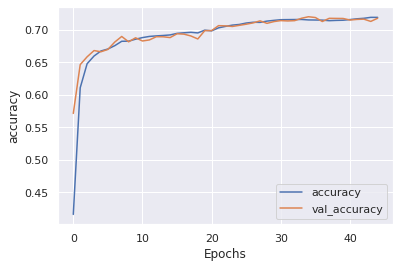

In [0]:
plot_graphs(history_9, 'accuracy')

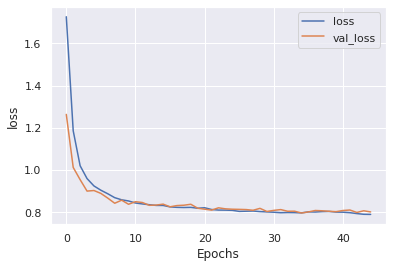

In [0]:
plot_graphs(history_9, 'loss')

In [0]:
predictions = model_9.predict(test_padded)
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: Credit reporting, credit repair services, or other personal consumer reports
Accuracy: 7361/9176

Class: Debt collection
Accuracy: 7401/8655

Class: Student loan
Accuracy: 1948/2178

Class: Credit card or prepaid card
Accuracy: 1127/2096

Class: Mortgage
Accuracy: 5018/5294

Class: Checking or savings account
Accuracy: 593/1262

Class: Money transfer, virtual currency, or money service
Accuracy: 361/501

Class: Payday loan, title loan, or personal loan
Accuracy: 162/392

Class: Vehicle loan or lease
Accuracy: 223/572

Class: Credit card
Accuracy: 987/1884

Class: Credit reporting
Accuracy: 555/3159

Class: Consumer Loan
Accuracy: 365/919

Class: Prepaid card
Accuracy: 1/73

Class: Bank account or service
Accuracy: 918/1447

Class: Money transfers
Accuracy: 16/150

Class: Payday loan
Accuracy: 20/175

None


In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.6938246960064487


In [0]:
# Save weights for model 9
checkpoint_path = '/content/gdrive/My Drive/Revolut-challenge/model/model_9.h5'

In [0]:
model_9.save_weights(checkpoint_path)

In [0]:
loaded_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='softmax')
])

In [0]:
loaded_model.load_weights(checkpoint_path)

# Model 10

In [0]:
model_10 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='softmax')
])
model_10.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_10.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          9401100   
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
Total params: 9,501,276
Trainable params: 9,501,276
Non-trainable params: 0
____________________________________________

In [0]:
num_epochs = 100
history_10 = model_10.fit(train_padded, 
                        train_labels, 
                        epochs=num_epochs,
                        batch_size=2048,
                        validation_data=(val_padded, validation_labels),
                        callbacks = [early_stopping])

Epoch 1/100
149/149 [==============================] - 36s 243ms/step - loss: 1.5088 - accuracy: 0.5195 - val_loss: 1.0352 - val_accuracy: 0.6569
Epoch 2/100
149/149 [==============================] - 35s 237ms/step - loss: 0.9649 - accuracy: 0.6713 - val_loss: 0.9018 - val_accuracy: 0.6883
Epoch 3/100
149/149 [==============================] - 36s 239ms/step - loss: 0.8564 - accuracy: 0.6986 - val_loss: 0.8297 - val_accuracy: 0.7075
Epoch 4/100
149/149 [==============================] - 36s 238ms/step - loss: 0.7997 - accuracy: 0.7155 - val_loss: 0.7954 - val_accuracy: 0.7181
Epoch 5/100
149/149 [==============================] - 35s 236ms/step - loss: 0.7602 - accuracy: 0.7279 - val_loss: 0.7555 - val_accuracy: 0.7271
Epoch 6/100
149/149 [==============================] - 35s 237ms/step - loss: 0.7301 - accuracy: 0.7376 - val_loss: 0.7554 - val_accuracy: 0.7303
Epoch 7/100
149/149 [==============================] - 35s 237ms/step - loss: 0.7045 - accuracy: 0.7473 - val_loss: 0.7303 -

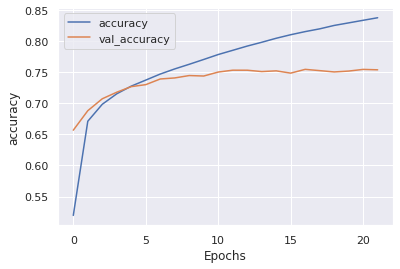

In [0]:
plot_graphs(history_10, 'accuracy')

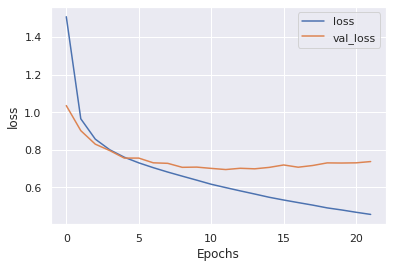

In [0]:
plot_graphs(history_10, 'loss')

In [0]:
predictions = model_10.predict(test_padded)
print(accuracy_per_class(predictions, np.array(df[df.data_type == 'test'].label)))

Class: Credit reporting, credit repair services, or other personal consumer reports
Accuracy: 7559/9176

Class: Debt collection
Accuracy: 7323/8655

Class: Student loan
Accuracy: 1953/2178

Class: Credit card or prepaid card
Accuracy: 1000/2096

Class: Mortgage
Accuracy: 4969/5294

Class: Checking or savings account
Accuracy: 655/1262

Class: Money transfer, virtual currency, or money service
Accuracy: 345/501

Class: Payday loan, title loan, or personal loan
Accuracy: 169/392

Class: Vehicle loan or lease
Accuracy: 161/572

Class: Credit card
Accuracy: 1106/1884

Class: Credit reporting
Accuracy: 755/3159

Class: Consumer Loan
Accuracy: 405/919

Class: Prepaid card
Accuracy: 1/73

Class: Bank account or service
Accuracy: 836/1447

Class: Money transfers
Accuracy: 43/150

Class: Payday loan
Accuracy: 0/175

None


In [0]:
print(f1_score_func(predictions, np.array(df[df.data_type == 'test'].label)))

0.702706862283058


# Summary:
Model 9 seems to be the best model that generalises well on validation data and with no over-fitting. The overall accuracy on validation data is close to 75% which is not that bad. We can expect this model to perform reasonably well on unseen textual data.

# If More time and better infrastructure:
* The data is highly imbalance and the actual task is to predict at Product Id level. Would have used upsampling techniques or some generative models to generate examples for minor classes. Or could have explored options to downsample major classes. Even at the Main Product level the data is highly imbalance.

* Would have tried ElMo embeddings on both traditional algorithms like Random Forest, Naive Bayes, SVM models or Neural Network models to check the performance compare to Glove Embeddings that I used currently.

* Would have also tried BERT Sentence Classification model and checked it's performance.

* I have also tried two step process to predict at the Sub Product level i.e. at the Product Id level by first developing model at Main Product level and then adding layers to predict sub products in order to generate product id by combining both the predictions. But the sub product id model is performing very poor. Would have explored more on this perspective and would have tried different models to comapre results

* Would have spent more time exploring the users complaint texts data to identify some patterns using unsupervised methods like topic modeling or clustering

* Currently used only Users Complaints and Products data but would have explored issues data as well to understand main issue and sub issue to identify features.